In [1]:
import scipy as sp
import scipy.misc as misc
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
data_dir = 'data/'

In [3]:
df_iiw = pd.read_csv(filepath_or_buffer=data_dir + 'data_iiw_complete.csv', sep=',',
                     names=['image_path', 'label_path'])
df_iiw = data_dir + df_iiw
df_sintel = pd.read_csv(filepath_or_buffer=data_dir + 'data_sintel_complete.csv', sep=',', 
                        names=['image_path', 'label_path'])
df_sintel = data_dir + df_sintel
df_sintel_test_unknown = pd.read_csv(filepath_or_buffer=data_dir + 'data_sintel_test_unknown.csv', 
                                     sep=',', names=['image_path', 'label_path'])
df_sintel_test_unknown['image_path'] = data_dir + df_sintel_test_unknown['image_path']
df_mit = pd.read_csv(filepath_or_buffer=data_dir + 'data_mit_complete.csv', sep=',', 
                     names=['image_path', 'albedo_label_path', 'shading_label_path'])
df_mit = data_dir + df_mit

In [4]:
def df_images_analysis(df, file_path, prefix=''):
    # TODO: if this function crashes it might be if one imports shape of a grayscale
    # image that consists only of (height, widht) information.
    """
    Appends image analysis columns to pd.DataFrame df.
    df must at least contain one column file_path where image paths are saved.
    These images are read and analysed.
    The following columns are appended to DataFrame df:
        'shape', 'height', 'nr_channels', 'aspect_ratio', 'nr_pixels'
    :param df: DataFrame that contains a column with paths to images
    :type df: pd.DataFrame
    :param file_path: column name of the DataFrame where the paths to images are located 
    :type file_path: str
    :param prefix: a (optional) prefix that can be inserted before the new defined column names
    :type prefix: str (default: '')
    :return: DataFrame df with above described appended columns
    """
    # read every file saved in column file_path and get shape:
    df[prefix + 'shape'] = df[file_path].apply(lambda x: sp.misc.imread(x).shape)
    # expand height, width and nr of channels to separate rows
    df[prefix + 'shape'] = df[prefix + 'shape'].apply(lambda x: x + (1,) if len(x)==2 else x)        
    df[[prefix + 'height', prefix + 'width', prefix + 'nr_channels']] = df[prefix + 'shape'].apply(pd.Series)
    # get aspect ratio:
    df[prefix + 'aspect_ratio'] = df[prefix + 'width'] / df[prefix + 'height']
    # get nr of pixels:
    df[prefix + 'nr_pixels'] = df[prefix + 'height'] * df[prefix + 'width'] * df[prefix + 'nr_channels']
    return df

def plot_stats(df, prefix=''):
    fixsize = (15, 4)
    ax = df[[prefix + 'height', prefix + 'width']].plot(kind='hist', bins=20, figsize=fixsize, alpha=0.7, fontsize=12)
    txt = ax.set_xlabel("Nr. pixels")
    ax = df[[prefix + 'nr_channels']].plot(kind='hist', bins=10, figsize=fixsize, fontsize=12)
    txt = ax.set_xlabel("Nr. channels")
    ax = df[[prefix + 'aspect_ratio']].plot(kind='hist', bins=10, figsize=fixsize, fontsize=12)
    txt = ax.set_xlabel("Aspect ratio (width / height)")
    ax = df[[prefix + 'nr_pixels']].plot(kind='hist', bins=20, figsize=fixsize, fontsize=12)
    txt = ax.set_xlabel("Nr. pixels")

In [5]:
def image_analysis(file_list, conf_int=2, average='mean'):
    """
    Analyses a list of images with respect to their shapes.
    This is necessary to get a preselection of images for shape adjustment in the next steps 
    (because each input to a CNN should have the same shape).
    :param file_list: list of locations of images (list of strings)
    :param conf_int: confidence interval 1 sigma, 2 sigma, ... (int, default: 2)
    :param average: select an average measure: mean or median (default: mean)
    :return: 3 outputs:
             - pd.DataFrame with all images and shapes that have valid shape and size
             - pd.DataFrame with all images that do not have the correct shape (mostly because 
               they only have one channel, -> grayscale image)
             - pd.DataFrame with all images with one shape value outside of the defined confidence interval
    """
    # create a dictionary with entries: key: image name, value: image shape
    d = {}
    for file in file_list:
        # lower-case filenames:
        file = file.lower()
        # only take .jpeg images from directory:
        if file[-5:] == '.jpeg':
            # write shape of each image to dictionary:
            d[file[:-5]] = np.array(misc.imread(image_dir + file).shape)      
    # transform dictionary to pandas DataFrame:
    df = pd.DataFrame.from_dict(d, orient="index")
    df.columns = ['height', 'width', 'channels']
    # Get entries with shape missmatch
    shape_missmatch = df[df.isnull().any(axis=1)]
    # remove miss-matched images, most probably grayscale images with just 1 channel:
    df.drop(shape_missmatch.index, axis=0, inplace=True)
    # only chose those values that lie in the confidence interval conf_int for each dimension:
    if average == 'mean':
        # ... using mean and standard deviation:
        df2 = df[((df >= df.mean() - conf_int * df.std()) & (df <= df.mean() + conf_int * df.std()))]
        # dismissed because values are out of bound:
        dim_missmatch = df[df2.isnull().any(axis=1)]
        df2.drop(dim_missmatch.index, axis=0, inplace=True)
        print('Ratio of remaining image after applying confidence interval: ' + str(df2['width'].count() / df['width'].count()))
    elif average == 'median':
        # ... using median and median absolute deviation
        df2 = df[((df >= df.median() - conf_int * df.mad()) & (df <= df.median() + conf_int * df.mad()))]
        # dismissed because values are out of bound:
        dim_missmatch = df[df2.isnull().any(axis=1)]
        df2.drop(dim_missmatch.index, axis=0, inplace=True)
        print('Ratio of remaining image after applying confidence interval: ' + str(df2['width'].count() / df['width'].count()))
    else: 
        raise ValueError('Not a valid average measure!')
    return df2.sort_index(), shape_missmatch.sort_index(), dim_missmatch.sort_index()

## Analysis of IIW data set:

In [6]:
df_iiw_analysis = df_images_analysis(df=df_iiw, file_path='image_path', prefix='image_')

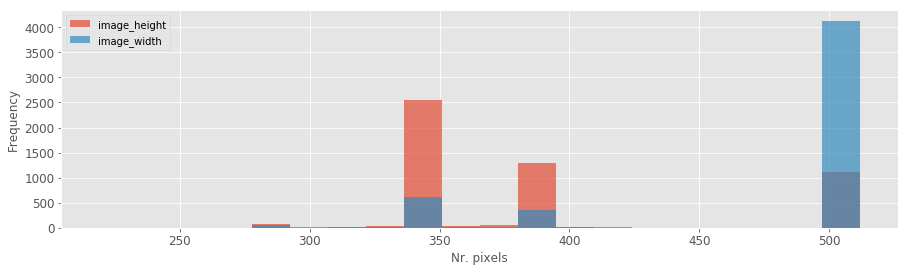

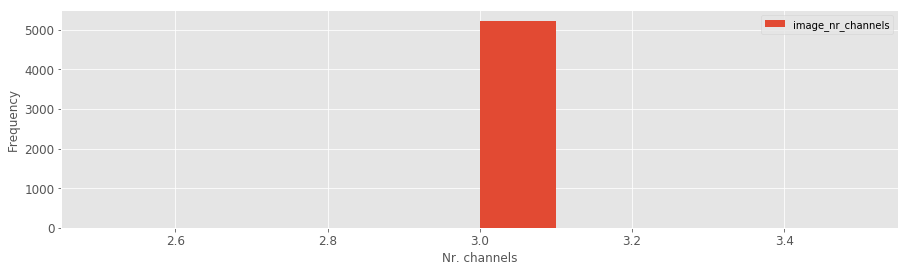

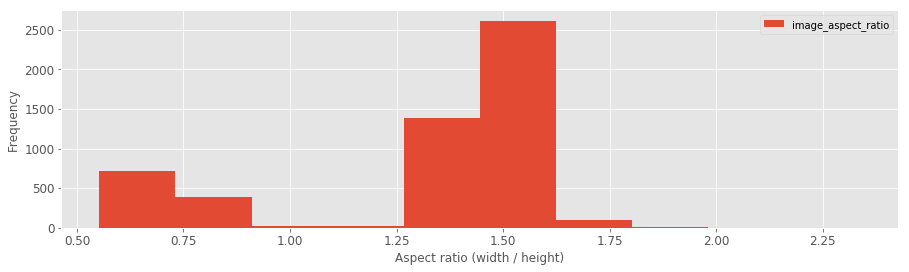

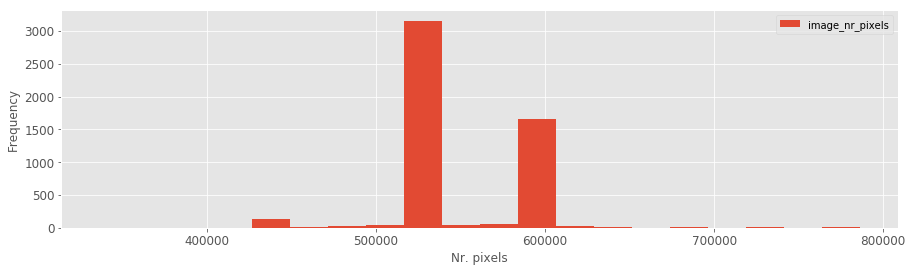

In [7]:
plot_stats(df_iiw_analysis, prefix='image_')

## Analysis of MPI Sintel data set:

In [8]:
df_sintel_analysis = df_images_analysis(df=df_sintel, file_path='image_path', prefix='image_')
df_sintel_analysis = df_images_analysis(df=df_sintel_analysis, file_path='label_path', prefix='label_')

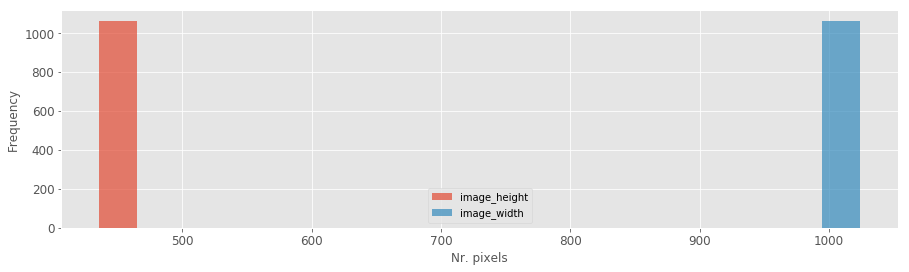

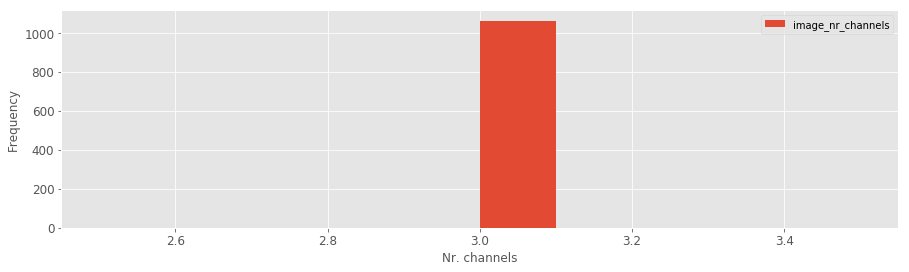

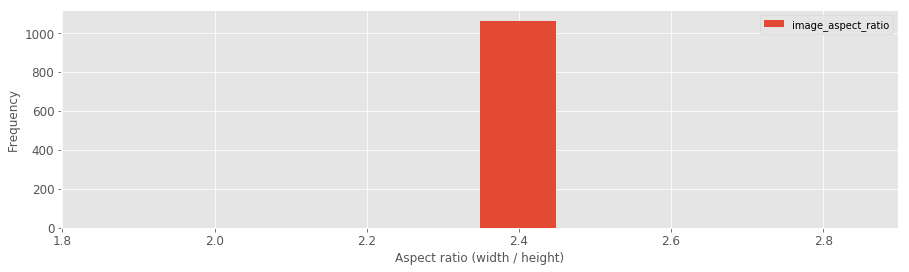

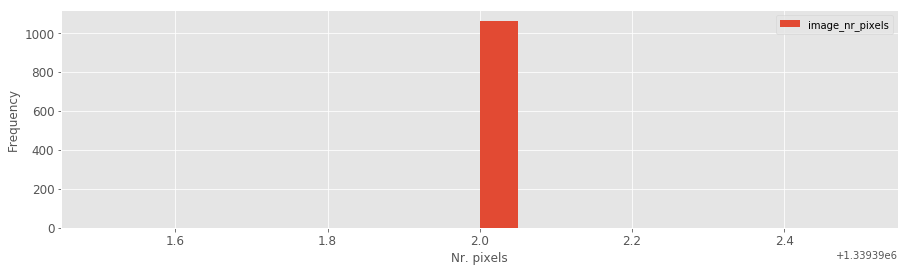

In [9]:
plot_stats(df=df_sintel_analysis, prefix='image_')

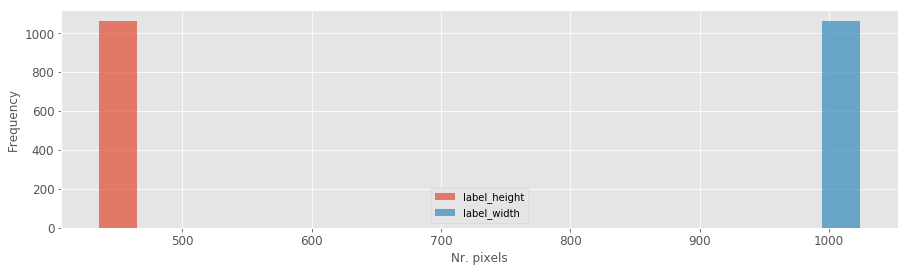

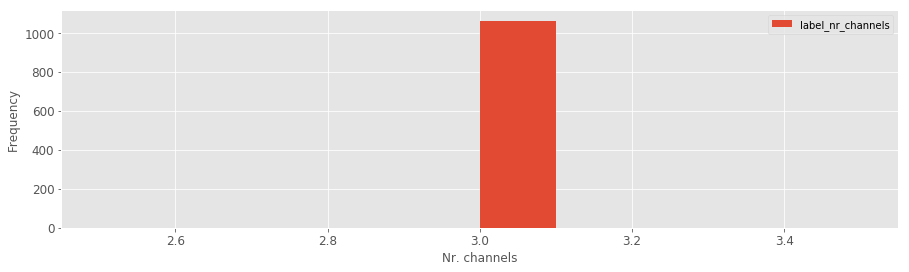

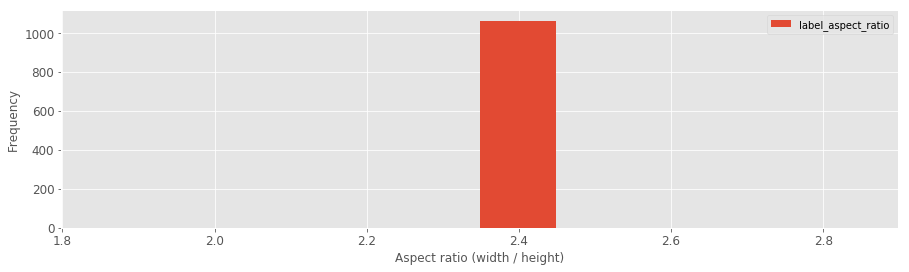

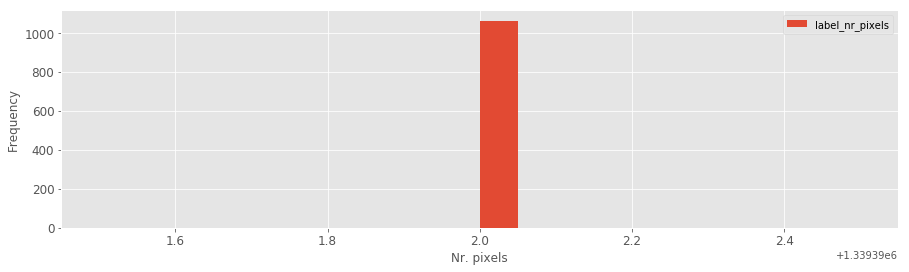

In [10]:
plot_stats(df=df_sintel_analysis, prefix='label_')

In [11]:
df_sintel_test_unknown_analysis = df_images_analysis(df=df_sintel_test_unknown, file_path='image_path', prefix='image_')

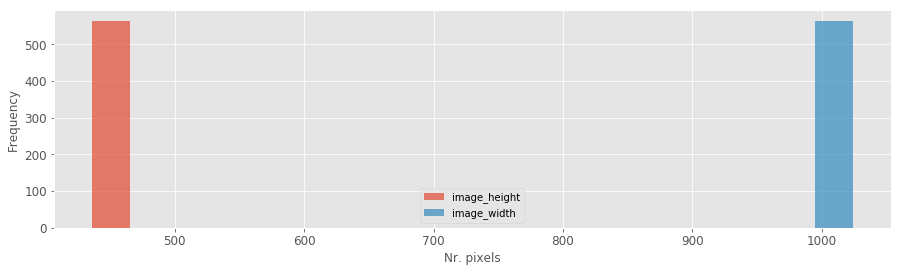

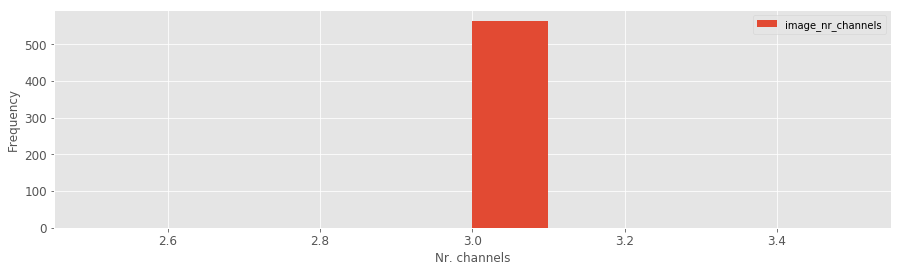

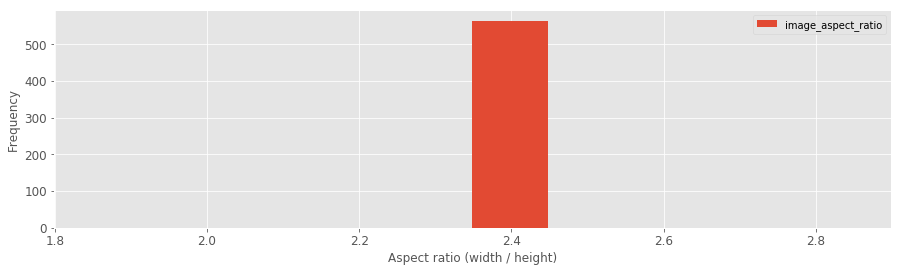

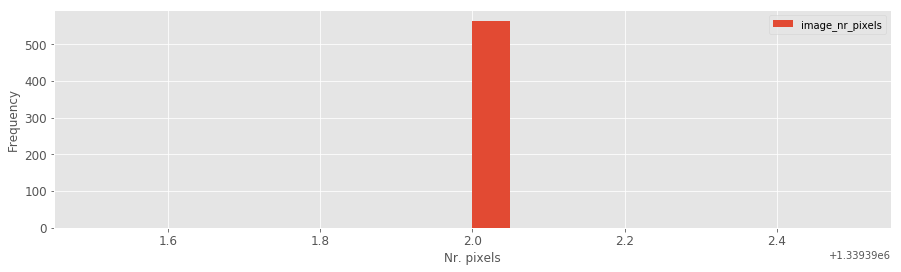

In [12]:
plot_stats(df=df_sintel_test_unknown_analysis, prefix='image_')

## Analysis of MIT data set:

In [13]:
df_mit_analysis = df_images_analysis(df=df_mit, file_path='image_path', prefix='image_')
df_mit_analysis = df_images_analysis(df=df_mit_analysis, file_path='albedo_label_path', prefix='albedo_label_')
df_mit_analysis = df_images_analysis(df=df_mit_analysis, file_path='shading_label_path', prefix='shading_label_')

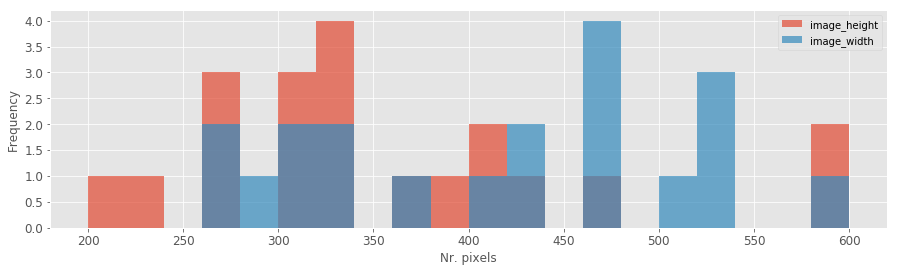

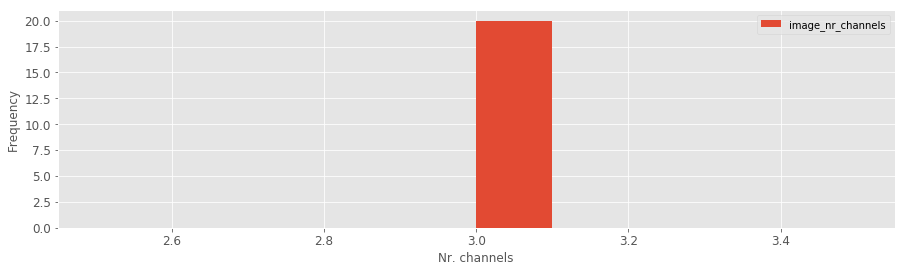

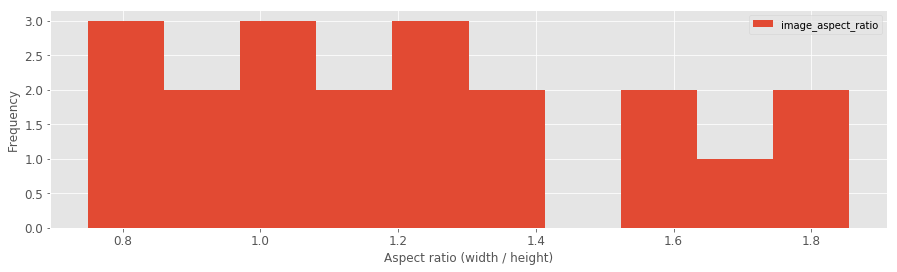

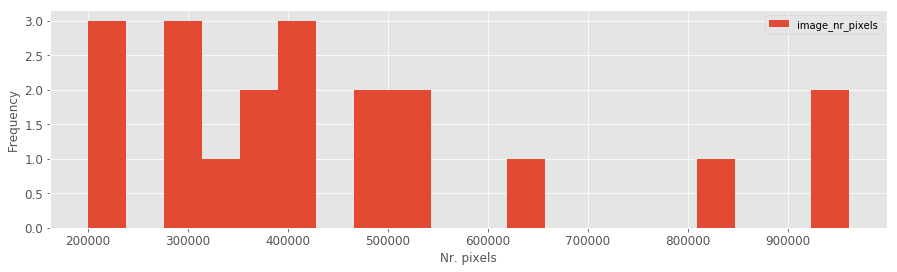

In [14]:
plot_stats(df=df_mit_analysis, prefix='image_')

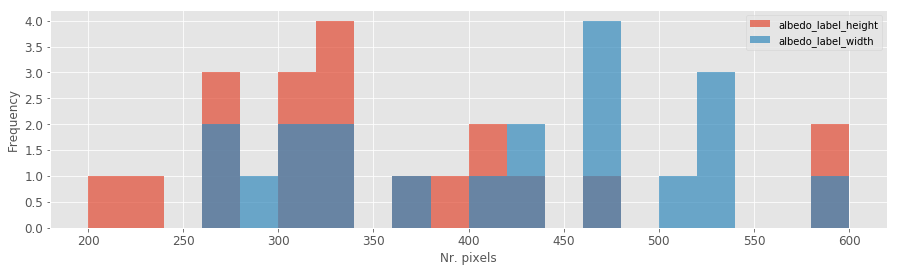

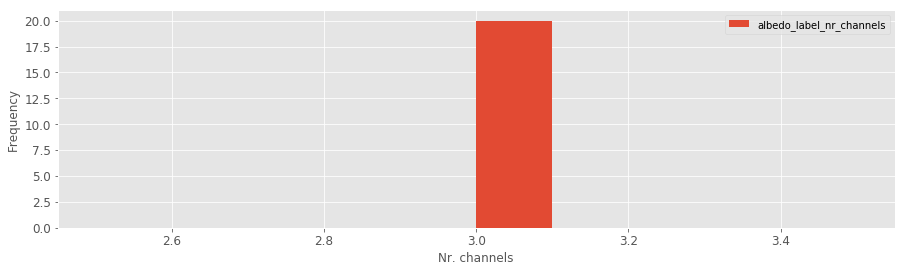

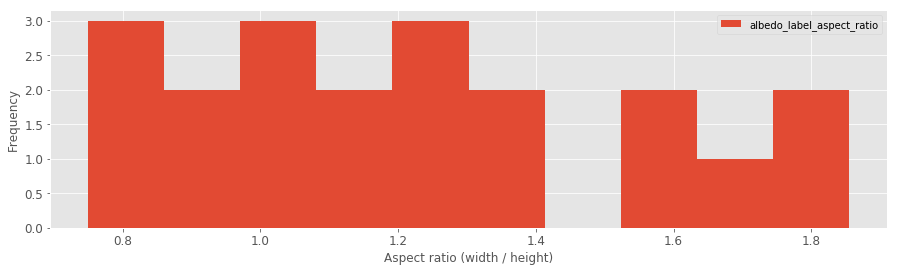

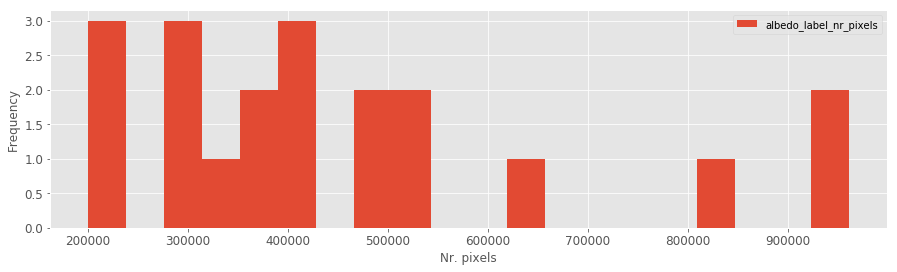

In [15]:
plot_stats(df=df_mit_analysis, prefix='albedo_label_')

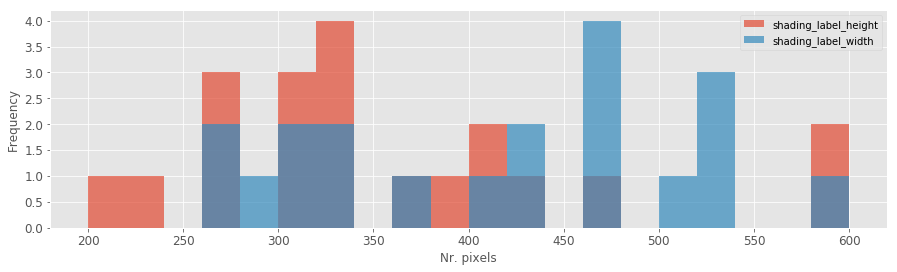

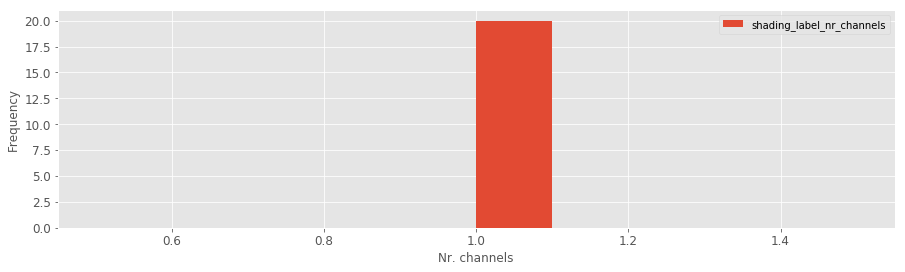

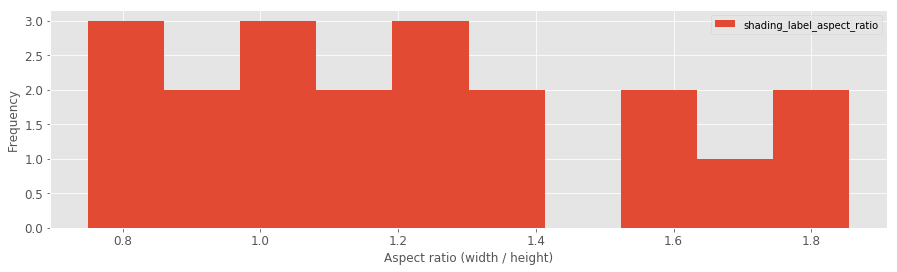

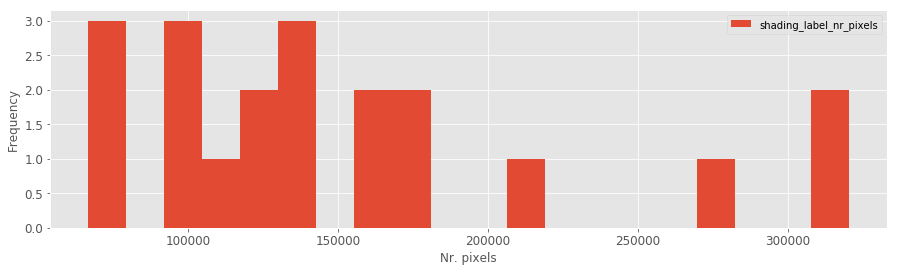

In [16]:
plot_stats(df=df_mit_analysis, prefix='shading_label_')